In [1]:
import numpy as np
import pandas as pd
from PyEMD import EMD, Visualisation
import scipy
import math
from sklearn import metrics

import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset

import ipdb

# 1. TCA function defining

In [2]:
def var_name(var, all_var=locals()):
    # get the name of the variable
    return [var_name for var_name in all_var if all_var[var_name] is var][0]


def np2csv(A):
    # store numpy to local csv file
    if type(A) == torch.Tensor:
        np.savetxt(var_name(A)+'.csv', A.detach().numpy(), delimiter=',')
    elif type(A) == np.ndarray:
        np.savetxt(var_name(A)+'.csv', A, delimiter=',')


def flat2vec(df):
    # df contains index and column tags
    # function: flatten a df (has 2 dimensions) to a 1D vector
    # the df data properties:
    # [[d1t1 d1t2 d1t3]
    #  [d2t1 d2t2 d2t3]
    #  [d3t1 d3t2 d3t3]]
    # dntn means day n time n
    
    # returned vector: 1D
    return np.array(df.loc[1:, 1:96].astype(float)).reshape(-1, 1).flatten()


def normalize(V):
    return ( V - min(V.flatten()) ) / ( max(V.flatten()) - min(V.flatten()) )

In [3]:
def sliding_window(T, T_org, seq_len, label_seq_len):

    # seq_len is equal to window_size
    # T (np.array) has dim: population, seq_len (window length)
    TT = T.reshape(-1, 1)
    K = TT.shape[0] - seq_len - label_seq_len + 1  # Li, et al., 2021, TRJ part C, pp. 8
    
    TT_org = T_org.reshape(-1, 1)

    # TT has dim: n, 1
    # assemble the data into 2D
    train_x = np.vstack(TT[i : K+i, 0] for i in range(seq_len)).T
    train_y = np.vstack(TT_org[i+seq_len : K+seq_len+i, 0] for i in range(label_seq_len)).T
    
    assert train_x.shape[0] == train_y.shape[0]

    # return size: [sequence_len, batch_size, inp/out dim = 1(default)]
    return train_x.T, train_y.T



In [4]:
def kernel(ker, X1, X2, gamma):
    K = None
    if not ker or ker == 'primal':
        K = X1
    elif ker == 'linear':
        if X2 is not None:
            # next line: K = X1.T@X2
            K = sklearn.metrics.pairwise.linear_kernel(np.asarray(X1).T, np.asarray(X2).T)
        else:
            K = X1.T@X1
    elif ker == 'rbf':
        if X2 is not None:
            K = sklearn.metrics.pairwise.rbf_kernel(np.asarray(X1).T, np.asarray(X2).T, gamma)
        else:
            K = sklearn.metrics.pairwise.rbf_kernel(np.asarray(X1).T, None, gamma)
    return K

In [5]:
class TCA:
    def __init__(self, kernel_type='primal', dim=30, lamb=1, gamma=1):
        '''
        Init func
        :param kernel_type: kernel, values: 'primal' | 'linear' | 'rbf'
        :param dim: dimension after transfer
        :param lamb: lambda value in equation
        :param gamma: kernel bandwidth for rbf kernel
        '''
        self.kernel_type = kernel_type
        self.dim = dim
        self.lamb = lamb
        self.gamma = gamma

    def fit(self, Xs, Xt):
        '''
        Transform Xs and Xt
        :param Xs: ns * n_feature, source feature
        :param Xt: nt * n_feature, target feature
        :return: Xs_new and Xt_new after TCA
        '''
        X = np.hstack((Xs.T, Xt.T))
        X /= np.linalg.norm(X, axis=0)
        m, n = X.shape
        ns, nt = len(Xs), len(Xt)
        e = np.vstack((1 / ns * np.ones((ns, 1)), -1 / nt * np.ones((nt, 1))))
        L = e * e.T
        L = L / np.linalg.norm(L, 'fro')
        H = np.eye(n) - 1 / n * np.ones((n, n))  # page 202
        K = kernel(self.kernel_type, X, None, gamma=self.gamma)
        n_eye = m if self.kernel_type == 'primal' else n
        a, b = np.linalg.multi_dot([K, L, K.T]) + self.lamb * np.eye(n_eye), np.linalg.multi_dot([K, H, K.T])
        w, V = scipy.linalg.eig(a, b)
        ind = np.argsort(w)
        A = V[:, ind[:self.dim]]
        Z = np.dot(A.T, K)
        Z /= np.linalg.norm(Z, axis=0)
        Xs_new, Xt_new = Z[:, :ns].T, Z[:, ns:].T
        return Xs_new, Xt_new, A

    def fit_predict(self, Xs, Ys, Xt, Yt):
        '''
        Transform Xs and Xt, then make predictions on target using 1NN
        :param Xs: ns * n_feature, source feature
        :param Ys: ns * 1, source label
        :param Xt: nt * n_feature, target feature
        :param Yt: nt * 1, target label
        :return: Accuracy and predicted_labels on the target domain
        '''
        Xs_new, Xt_new = self.fit(Xs, Xt)
        clf = KNeighborsClassifier(n_neighbors=1)
        clf.fit(Xs_new, Ys.ravel())
        y_pred = clf.predict(Xt_new)
        acc = sklearn.metrics.accuracy_score(Yt, y_pred)
        return acc, y_pred, Xs_new, Xt_new

In [6]:
Xs.shape

NameError: name 'Xs' is not defined

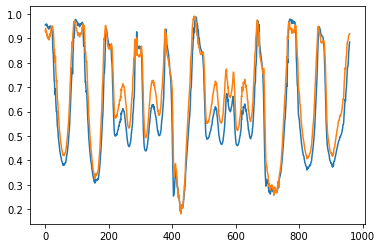

In [18]:
X = np.hstack([Xs.T, Xt.T]
K = kernel('linear', ), None, gamma=None)
Z = np.dot(A.T, K)
Z /= np.linalg.norm(Z, axis=0)
Xs_new_re = Z[:, :960]
plt.plot(Xs_new_re[1, :])
plt.plot(Xs_new[1, :])

**$X_{S, n_s\times n_{feature}}$**

**$X_{T, n_t\times n_{feature}}$**

**$X_{S, n_s\times n_{feature}}$** = **$((A^T)_{n_{feature}\times(n_s+n_t)}K_{(n_s+n_t)\times(n_s+n_t)})^T$**[:ns, :]

# 2. Learning Part

## 2.a. Load Data

In [7]:
src_domain = np.array(pd.read_csv('data/siteM4_2210B_20210101_20210131.csv'))[:10, :]  # upstream
data_target = np.array(pd.read_csv('data/siteM4_2168B_20210101_20210131.csv'))  # downstream

date_choosen = np.arange(4,6,1)
tar_domain = data_target[date_choosen, :].reshape(-1, 96)
tgt_validation = data_target[date_choosen[-1]:date_choosen[-1]+2, :].reshape(-1, 96)

### 2.a.i. preview data

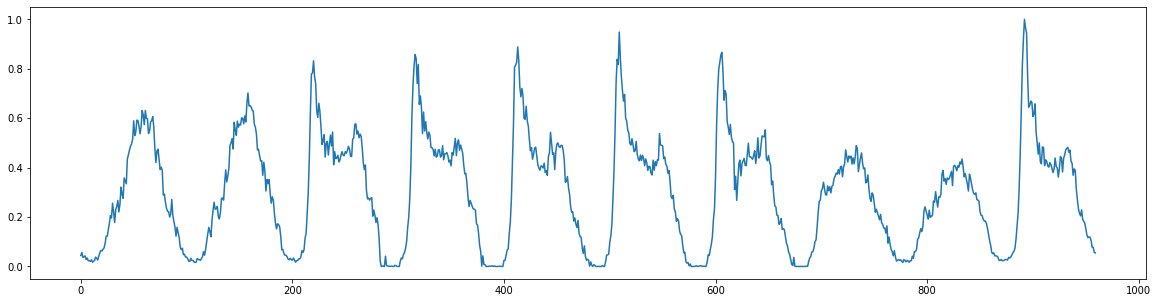

In [8]:
src_domain_emd = normalize(src_domain.flatten())
plt.figure(figsize=(20,5))
plt.plot(src_domain_emd)
tar_domain_emd = normalize(tar_domain.flatten())

## 2.b. Extract Features using EMD

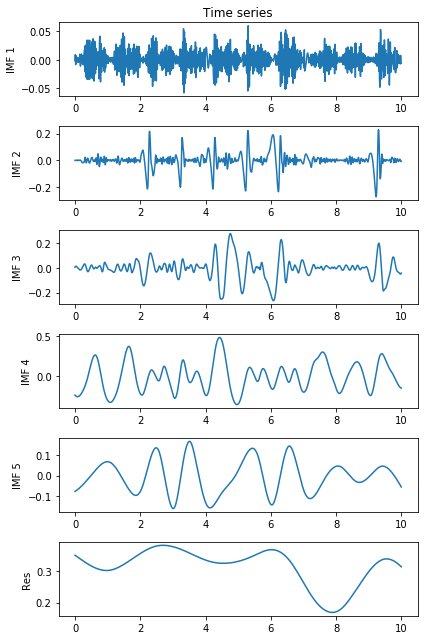

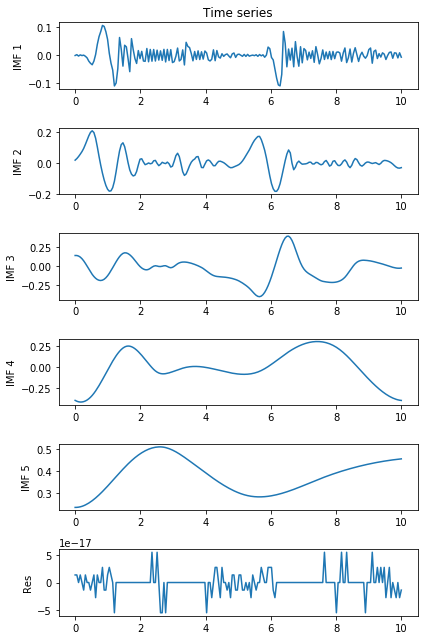

In [9]:
emd = EMD()
emd.emd(src_domain_emd, max_imf=5)
imfs_src, res_src = emd.get_imfs_and_residue()
vis = Visualisation()
t_src = np.linspace(0, 10, src_domain_emd.shape[0])
vis.plot_imfs(imfs=imfs_src, residue=res_src, t=t_src, include_residue=True)
vis.show()

emd = EMD()
emd.emd(tar_domain_emd, max_imf=5)
imfs_tar, res_tar = emd.get_imfs_and_residue()
vis = Visualisation()
t_tar = np.linspace(0, 10, tar_domain_emd.shape[0])
vis.plot_imfs(imfs=imfs_tar, residue=res_tar, t=t_tar, include_residue=True)
vis.show()


### 2.b.i. assemble Xs and Xt

Data type of **Xs**: [normalized_raw_data (fisrt row); emd_results (rest rows)]

In [10]:
#data_dim = min(imfs_src.shape[0], imfs_tar.shape[0])  # to be verified ***********************
Xs = np.concatenate([src_domain_emd.reshape(1, -1), imfs_src, res_src.reshape(1, -1)])
Xt = np.concatenate([tar_domain_emd.reshape(1, -1), imfs_tar, res_tar.reshape(1, -1)])

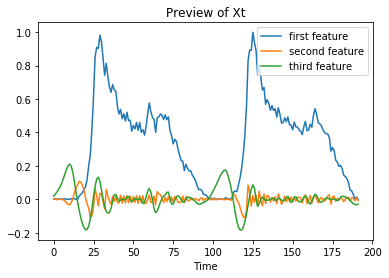

In [11]:
plt.plot(Xt[0, :], label='first feature')
plt.plot(Xt[1, :], label='second feature')
plt.plot(Xt[2, :], label='third feature')
plt.title('Preview of Xt')
plt.xlabel('Time')
plt.legend()

## 2.c. Hyperparameters

In [12]:
inp_dim = Xs.shape[0]
label_dim = Xs.shape[0]
label_seq_len = 1
# batch_size = full batch
seq_len = 10
reduced_dim = 1
hid_dim = 16
layers = 3
lamb = 3

hyper = {
    'inp_dim':inp_dim,
    'label_dim':label_dim,
    'label_seq_len':label_seq_len,
    'seq_len':seq_len,
    'reduced_dim':reduced_dim,
    'hid_dim':hid_dim,
    'layers':layers,
    'lamb':lamb}
hyper = pd.DataFrame(hyper, index=['Values'])

## 2.d. Apply Domain Adaptation using TCA (see part 1) upon Xs and Xt

In [13]:
hyper

,inp_dim,label_dim,label_seq_len,seq_len,reduced_dim,hid_dim,layers,lamb
Values,7,7,1,10,1,16,3,3


In [14]:
inp_dim -= reduced_dim
label_dim -= reduced_dim

tca = TCA(kernel_type='linear', dim=inp_dim, lamb=lamb, gamma=1)
Xs_new, Xt_new, A = tca.fit(Xs.T, Xt.T)
Xs_new, Xt_new = Xs_new.T, Xt_new.T

print(Xs_new.shape)
print(Xt_new.shape)

np2csv(Xs_new)
np2csv(Xt_new)

(6, 960)
(6, 192)


## 2.e. The LSTM network, hyperparameters see part 2.a.

In [52]:
class LSTM(nn.Module):
    def __init__(self, inp_dim, out_dim, hid_dim, layers):
        super(LSTM, self).__init__()

        self.out_dim = out_dim
        
        self.lstm = nn.LSTM(inp_dim, hid_dim, layers, dropout=0.1)
        
        self.fc = nn.Sequential(
            nn.Linear(hid_dim, out_dim)
        )  # regression
    
    def forward(self, x):
        # input: (seq_len, batchsize, input_dim)
        # output: (seq_len, batchsize, hid_dim)
        #ipdb.set_trace()
        y = self.lstm(x)[0]  # y, (h, c) = self.rnn(x)
        
        y = self.fc(y)  # fully connected layer
        
        return y[-1, :, :]



In [53]:
def assemble(X):
    '''
    X = torch.tensor(X)
    batch_num = X.shape[0] // (seq_len*batch_size)
    new_X = torch.zeros(seq_len, batch_size, dim, batch_num)
    for i in range(batch_num):
        for j in range(batch_size):
            #ipdb.set_trace()
            new_X[:, j, :, i] = X[seq_len*(i*j+j):seq_len*(i*j+j+1), :]
    '''
    new_X = X[:, :, np.newaxis]
    return new_X

## 2.e.i. assemble data and build model

Note: **Xs** is the result of EMD, and is designated for TCA to generate **Xs_new**

**src_domain** and **tar_domain** are the raw data sets



In [54]:
def dataloader(Xs_new, Xt_new, seq_len, label_seq_len, inp_dim, label_dim):
    batch_size = Xs_new.shape[1] + Xt_new.shape[1] + 2 * (- seq_len - label_seq_len + 1)
    train_x = np.zeros([ seq_len, batch_size, inp_dim ])  # seq_len, batch_size, inp_dim
    train_y = np.zeros([ label_seq_len, batch_size, label_dim ])

    target_data_num = Xt_new.shape[1] - seq_len - label_seq_len + 1
    target_x = np.zeros([ seq_len, target_data_num, inp_dim ])
    target_y = np.zeros([ label_seq_len, target_data_num, label_dim ])


    for i in range(inp_dim):
        x_i_src, y_i_src = sliding_window(Xs_new[i, :], Xs[i, :], seq_len, label_seq_len)  # i means i^th dim
        x_i_tar, y_i_tar = sliding_window(Xt_new[i, :], Xt[i, :], seq_len, label_seq_len)  # i means i^th dim

        train_x[:, :, i] += np.concatenate([x_i_src, x_i_tar], axis=1)
        target_x[:, :, i] += x_i_tar
        train_y[:, :, i] += np.concatenate([y_i_src, y_i_tar], axis=1)
        target_y[:, :, i] += y_i_tar
    
    train_x = torch.tensor(train_x, dtype=torch.float32, device=device)
    train_y = torch.tensor(train_y, dtype=torch.float32, device=device)
    target_x = torch.tensor(target_x, dtype=torch.float32, device=device)
    target_y = torch.tensor(target_y, dtype=torch.float32, device=device)
        
    return train_x, train_y, target_x, target_y

In [55]:
train_x, train_y, target_x, target_y = dataloader(Xs_new, Xt_new, seq_len, label_seq_len, inp_dim, label_dim)

# build model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = LSTM(inp_dim, label_dim, hid_dim, layers).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
#scheduler =  torch.optim.lr_scheduler.StepLR(optimizer, 0.7)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if sys.path[0] == '':
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  del sys.path[0]


## 2.e.ii. train

In [56]:
# train
num_epoch = 5001

for e in range(num_epoch):
    # train_x: [seq_len, batch_size, inp_dim, batch#]
    #ipdb.set_trace()
    out = net(train_x)

    loss = (out - train_y[0, :, :]) ** 2
    loss = loss.mean()

    optimizer.zero_grad()
    loss.backward()

    optimizer.step()
    
    if e%1000==0:
        print('Epoch: {:4}, Loss: {:.7f}'.format(e, loss.item()))
        #scheduler.step()
        

Epoch:    0, Loss: 0.0967072
Epoch: 1000, Loss: 0.0006471
Epoch: 2000, Loss: 0.0003901
Epoch: 3000, Loss: 0.0002645
Epoch: 4000, Loss: 0.0002355
Epoch: 5000, Loss: 0.0002068


## 2.e.iii. test

In [61]:
Xs.shape

(7, 960)

In [62]:
Xt.shape

(7, 192)

In [63]:
A.shape

(1152, 6)

In [75]:
Xs_new.shape

(6, 960)

0

In [84]:
Xs_new.shape

(6, 960)

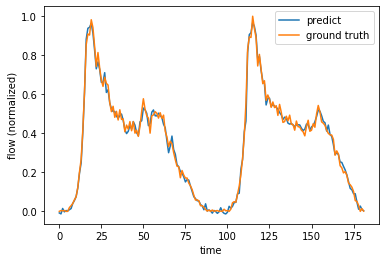

In [57]:
pred_y = net(target_x)
plt.plot(pred_y.detach().numpy()[:, 0], label='predict')
plt.plot(target_y.detach().numpy()[0, :, 0], label='ground truth')
plt.xlabel('time')
plt.ylabel('flow (normalized)')
plt.legend()

# 3. Post Analysis, Test

In [58]:
def mape(actual, predict): 
    tmp, n = 0.0, 0
    for i in range(0, len(actual)):
        if actual[i] != 0:
            tmp += math.fabs((actual[i]-predict[i])/(actual[i]+1))
            n += 1
    return (tmp/n)

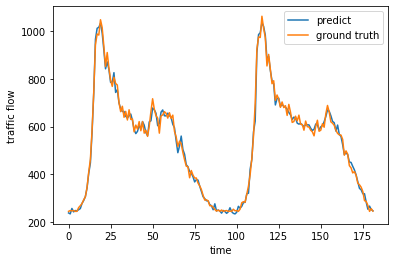

In [59]:
ground_truth_denorm = tar_domain_emd[seq_len:]*(max(src_domain.flatten()) - min(src_domain.flatten())) +np.mean(src_domain.flatten())
pred_y_denorm = pred_y.detach().numpy()[:, 0]*(max(src_domain.flatten()) - min(src_domain.flatten())) +np.mean(src_domain.flatten())

plt.plot(pred_y_denorm, label='predict')
plt.plot(ground_truth_denorm, label='ground truth')
plt.xlabel('time')
plt.ylabel('traffic flow')
plt.legend()

In [60]:
MSE = metrics.mean_squared_error(ground_truth_denorm, pred_y_denorm)
MAE = metrics.mean_absolute_error(ground_truth_denorm, pred_y_denorm)
MAPE = mape(ground_truth_denorm, pred_y_denorm)
SMAPE2 = np.sum(np.abs(ground_truth_denorm - pred_y_denorm)) / np.sum(ground_truth_denorm + pred_y_denorm)
R2 = 1 - np.sum((ground_truth_denorm - pred_y_denorm)**2) / np.sum((ground_truth_denorm - np.mean(ground_truth_denorm))**2)

print("MSE:", MSE)
print("MAE:", MAE)
print("MAPE:", MAPE)
print("SMAPE2:", SMAPE2)
print("R2:", R2)

MSE: 303.56777150148525
MAE: 13.52059563287535
MAPE: 0.026214676058367893
SMAPE2: 0.012537689240198253
R2: 0.9932990354421349


# 4. Train Only Use Target Data Set

In [22]:
target_x_train, target_y_train = sliding_window(normalize(tar_domain), normalize(tar_domain), seq_len, label_seq_len)
target_x_test, target_y_test = sliding_window(normalize(tgt_validation), normalize(tgt_validation), seq_len, label_seq_len)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if sys.path[0] == '':
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  del sys.path[0]


In [23]:
# build model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net2 = LSTM(inp_dim=1, out_dim=1, hid_dim=hid_dim, layers=layers).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
#scheduler =  torch.optim.lr_scheduler.StepLR(optimizer, 0.7)


target_x_train = torch.tensor(target_x_train[:, :, np.newaxis], dtype=torch.float32, device=device)
target_y_train = torch.tensor(target_y_train[:, :, np.newaxis], dtype=torch.float32, device=device)
target_x_test = torch.tensor(target_x_test[:, :, np.newaxis], dtype=torch.float32, device=device)
target_y_test = torch.tensor(target_y_test[:, :, np.newaxis], dtype=torch.float32, device=device)

In [24]:
# train
num_epoch = 5001

for e in range(num_epoch):
    # train_x: [seq_len, batch_size, inp_dim, batch#]
    #ipdb.set_trace()
    out = net2(target_x_train)

    loss = (out - target_y_train[0, :, :]) ** 2
    loss = loss.mean()

    optimizer.zero_grad()
    loss.backward()

    optimizer.step()
    
    if e%1000==0:
        print('Epoch: {:4}, Loss: {:.7f}'.format(e, loss.item()))
        #scheduler.step()

Epoch:    0, Loss: 0.2998154
Epoch:  100, Loss: 0.2996521
Epoch:  200, Loss: 0.2994980
Epoch:  300, Loss: 0.2998039
Epoch:  400, Loss: 0.3000962
Epoch:  500, Loss: 0.2998538
Epoch:  600, Loss: 0.2998132
Epoch:  700, Loss: 0.2997800
Epoch:  800, Loss: 0.2997332
Epoch:  900, Loss: 0.3000211
Epoch: 1000, Loss: 0.2997547


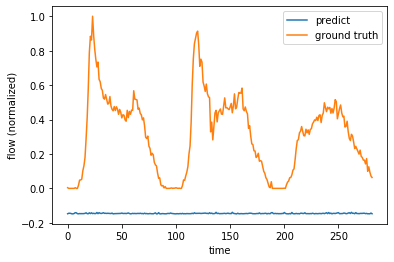

In [25]:
pred_y = net2(target_x_test)
plt.plot(pred_y.detach().numpy()[:, 0], label='predict')
plt.plot(target_y_test.detach().numpy()[0, :, 0], label='ground truth')
plt.xlabel('time')
plt.ylabel('flow (normalized)')
plt.legend()